# Ranking features with XGBoost

In [310]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import shap


## Exploration of Data

In [311]:
df = pd.read_csv('Dataset/train.csv/train.csv')
print(df.shape)
print('-'*100)
print(df.info())
print('-'*100)
display(df.describe())
print('-'*100)
display(df.isnull().sum())

cols_with_na = df.columns[df.isna().any()].tolist()
print(f"Number of columns with NAN: {len(cols_with_na)}")


(30471, 292)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB
None
----------------------------------------------------------------------------------------------------


,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


----------------------------------------------------------------------------------------------------


id                       0
timestamp                0
full_sq                  0
life_sq               6383
floor                  167
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 292, dtype: int64

Number of columns with NAN: 51


In [312]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

df.drop(['timestamp'], axis=1, inplace=True)

### Handpicked categorical features

In [313]:
categorical_cols = [
'id',
# 'timestamp',
'month',
'year',
'floor',
'material',
'max_floor',
'build_year',
'state',
'product_type',
'sub_area',
'ID_railroad_station_walk',
'ID_railroad_station_avto',
'water_1line',
'ID_big_road1',
'big_road1_1line',
'ID_big_road2',
'railroad_1line',
'ID_railroad_terminal',
'ID_bus_terminal',
'ecology',
'nuclear_reactor_raion',
'culture_objects_top_25',
'thermal_power_plant_raion',
'incineration_raion',
'oil_chemistry_raion',
'radiation_raion',
'railroad_terminal_raion',
'big_market_raion',
'nuclear_reactor_raion',
'detention_facility_raion',
'ID_metro',
]

# one hot
one_hot_cols = [
    'product_type',
    'sub_area',
    'ecology',
]

# label encoding
le_cols = [
'floor',
'culture_objects_top_25',
'thermal_power_plant_raion',
'incineration_raion',
'oil_chemistry_raion',
'radiation_raion',
'railroad_terminal_raion',
'big_market_raion',
'nuclear_reactor_raion',
'detention_facility_raion',
'water_1line',
'big_road1_1line',
'railroad_1line',
'month',
'year',
'material',
'max_floor',
'build_year',
'state',
]



useless_cols = [
'id',
# 'timestamp',
# 'floor',
# 'material',
# 'max_floor',
# 'build_year',
# 'state',
# 'product_type',
# 'sub_area',
'ID_railroad_station_walk',
'ID_railroad_station_avto',
# 'water_1line',
'ID_big_road1',
# 'big_road1_1line',
'ID_big_road2',
# 'railroad_1line',
'ID_railroad_terminal',
'ID_bus_terminal',
# 'ecology',
# 'nuclear_reactor_raion',
# 'culture_objects_top_25',
# 'thermal_power_plant_raion',
# 'incineration_raion',
# 'oil_chemistry_raion',
# 'radiation_raion',
# 'railroad_terminal_raion',
# 'big_market_raion',
# 'nuclear_reactor_raion',
# 'detention_facility_raion',
'ID_metro',

]


numeric_cols =[
'full_sq',
'life_sq',
'num_room',
'kitch_sq',
'area_m',
'raion_popul',
'green_zone_part',
'indust_part',
'children_preschool',
'preschool_quota',
'preschool_education_centers_raion',
'children_school',
'school_quota',
'school_education_centers_raion',
'school_education_centers_top_20_raion',
'hospital_beds_raion',
'healthcare_centers_raion',
'university_top_20_raion',
'sport_objects_raion',
'additional_education_raion',
'culture_objects_top_25_raion',
'shopping_centers_raion',
'office_raion',
'full_all',
'male_f',
'female_f',
'young_all',
'young_male',
'young_female',
'work_all',
'work_male',
'work_female',
'ekder_all',
'ekder_male',
'ekder_female',
'0_6_all',
'0_6_male',
'0_6_female',
'7_14_all',
'7_14_male',
'7_14_female',
'0_17_all',
'0_17_male',
'0_17_female',
'16_29_all',
'16_29_male',
'16_29_female',
'0_13_all',
'0_13_male',
'0_13_female',
'raion_build_count_with_material_info',
'build_count_block',
'build_count_wood',
'build_count_frame',
'build_count_brick',
'build_count_monolith',
'build_count_panel',
'build_count_foam',
'build_count_slag',
'build_count_mix',
'raion_build_count_with_builddate_info',
'build_count_before_1920',
'build_count_1921-1945',
'build_count_1946-1970',
'build_count_1971-1995',
'build_count_after_1995',
'metro_min_avto',
'metro_km_avto',
'metro_min_walk',
'metro_km_walk',
'kindergarten_km',
'school_km',
'park_km',
'green_zone_km',
'industrial_km',
'water_treatment_km',
'cemetery_km',
'incineration_km',
'railroad_station_walk_km',
'railroad_station_walk_min',
'railroad_station_avto_km',
'railroad_station_avto_min',
'public_transport_station_km',
'public_transport_station_min_walk',
'water_km',
'mkad_km',
'ttk_km',
'sadovoe_km',
'bulvar_ring_km',
'kremlin_km',
'big_road1_km',
'big_road2_km',
'railroad_km',
'zd_vokzaly_avto_km',
'bus_terminal_avto_km',
'oil_chemistry_km',
'nuclear_reactor_km',
'radiation_km',
'power_transmission_line_km',
'thermal_power_plant_km',
'ts_km',
'big_market_km',
'market_shop_km',
'fitness_km',
'swim_pool_km',
'ice_rink_km',
'stadium_km',
'basketball_km',
'hospice_morgue_km',
'detention_facility_km',
'public_healthcare_km',
'university_km',
'workplaces_km',
'shopping_centers_km',
'office_km',
'additional_education_km',
'preschool_km',
'big_church_km',
'church_synagogue_km',
'mosque_km',
'theater_km',
'museum_km',
'exhibition_km',
'catering_km',
'green_part_500',
'prom_part_500',
'office_count_500',
'office_sqm_500',
'trc_count_500',
'trc_sqm_500',
'cafe_count_500',
'cafe_sum_500_min_price_avg',
'cafe_sum_500_max_price_avg',
'cafe_avg_price_500',
'cafe_count_500_na_price',
'cafe_count_500_price_500',
'cafe_count_500_price_1000',
'cafe_count_500_price_1500',
'cafe_count_500_price_2500',
'cafe_count_500_price_4000',
'cafe_count_500_price_high',
'big_church_count_500',
'church_count_500',
'mosque_count_500',
'leisure_count_500',
'sport_count_500',
'market_count_500',
'green_part_1000',
'prom_part_1000',
'office_count_1000',
'office_sqm_1000',
'trc_count_1000',
'trc_sqm_1000',
'cafe_count_1000',
'cafe_sum_1000_min_price_avg',
'cafe_sum_1000_max_price_avg',
'cafe_avg_price_1000',
'cafe_count_1000_na_price',
'cafe_count_1000_price_500',
'cafe_count_1000_price_1000',
'cafe_count_1000_price_1500',
'cafe_count_1000_price_2500',
'cafe_count_1000_price_4000',
'cafe_count_1000_price_high',
'big_church_count_1000',
'church_count_1000',
'mosque_count_1000',
'leisure_count_1000',
'sport_count_1000',
'market_count_1000',
'green_part_1500',
'prom_part_1500',
'office_count_1500',
'office_sqm_1500',
'trc_count_1500',
'trc_sqm_1500',
'cafe_count_1500',
'cafe_sum_1500_min_price_avg',
'cafe_sum_1500_max_price_avg',
'cafe_avg_price_1500',
'cafe_count_1500_na_price',
'cafe_count_1500_price_500',
'cafe_count_1500_price_1000',
'cafe_count_1500_price_1500',
'cafe_count_1500_price_2500',
'cafe_count_1500_price_4000',
'cafe_count_1500_price_high',
'big_church_count_1500',
'church_count_1500',
'mosque_count_1500',
'leisure_count_1500',
'sport_count_1500',
'market_count_1500',
'green_part_2000',
'prom_part_2000',
'office_count_2000',
'office_sqm_2000',
'trc_count_2000',
'trc_sqm_2000',
'cafe_count_2000',
'cafe_sum_2000_min_price_avg',
'cafe_sum_2000_max_price_avg',
'cafe_avg_price_2000',
'cafe_count_2000_na_price',
'cafe_count_2000_price_500',
'cafe_count_2000_price_1000',
'cafe_count_2000_price_1500',
'cafe_count_2000_price_2500',
'cafe_count_2000_price_4000',
'cafe_count_2000_price_high',
'big_church_count_2000',
'church_count_2000',
'mosque_count_2000',
'leisure_count_2000',
'sport_count_2000',
'market_count_2000',
'green_part_3000',
'prom_part_3000',
'office_count_3000',
'office_sqm_3000',
'trc_count_3000',
'trc_sqm_3000',
'cafe_count_3000',
'cafe_sum_3000_min_price_avg',
'cafe_sum_3000_max_price_avg',
'cafe_avg_price_3000',
'cafe_count_3000_na_price',
'cafe_count_3000_price_500',
'cafe_count_3000_price_1000',
'cafe_count_3000_price_1500',
'cafe_count_3000_price_2500',
'cafe_count_3000_price_4000',
'cafe_count_3000_price_high',
'big_church_count_3000',
'church_count_3000',
'mosque_count_3000',
'leisure_count_3000',
'sport_count_3000',
'market_count_3000',
'green_part_5000',
'prom_part_5000',
'office_count_5000',
'office_sqm_5000',
'trc_count_5000',
'trc_sqm_5000',
'cafe_count_5000',
'cafe_sum_5000_min_price_avg',
'cafe_sum_5000_max_price_avg',
'cafe_avg_price_5000',
'cafe_count_5000_na_price',
'cafe_count_5000_price_500',
'cafe_count_5000_price_1000',
'cafe_count_5000_price_1500',
'cafe_count_5000_price_2500',
'cafe_count_5000_price_4000',
'cafe_count_5000_price_high',
'big_church_count_5000',
'church_count_5000',
'mosque_count_5000',
'leisure_count_5000',
'sport_count_5000',
'market_count_5000',
'price_doc',    
]



In [314]:
for c in categorical_cols:
    df[c] = df[c].astype('category')

In [315]:
cafe_list = []
for p in df.select_dtypes(include='number').columns:
    if 'cafe' in p:
        cafe_list.append(p)

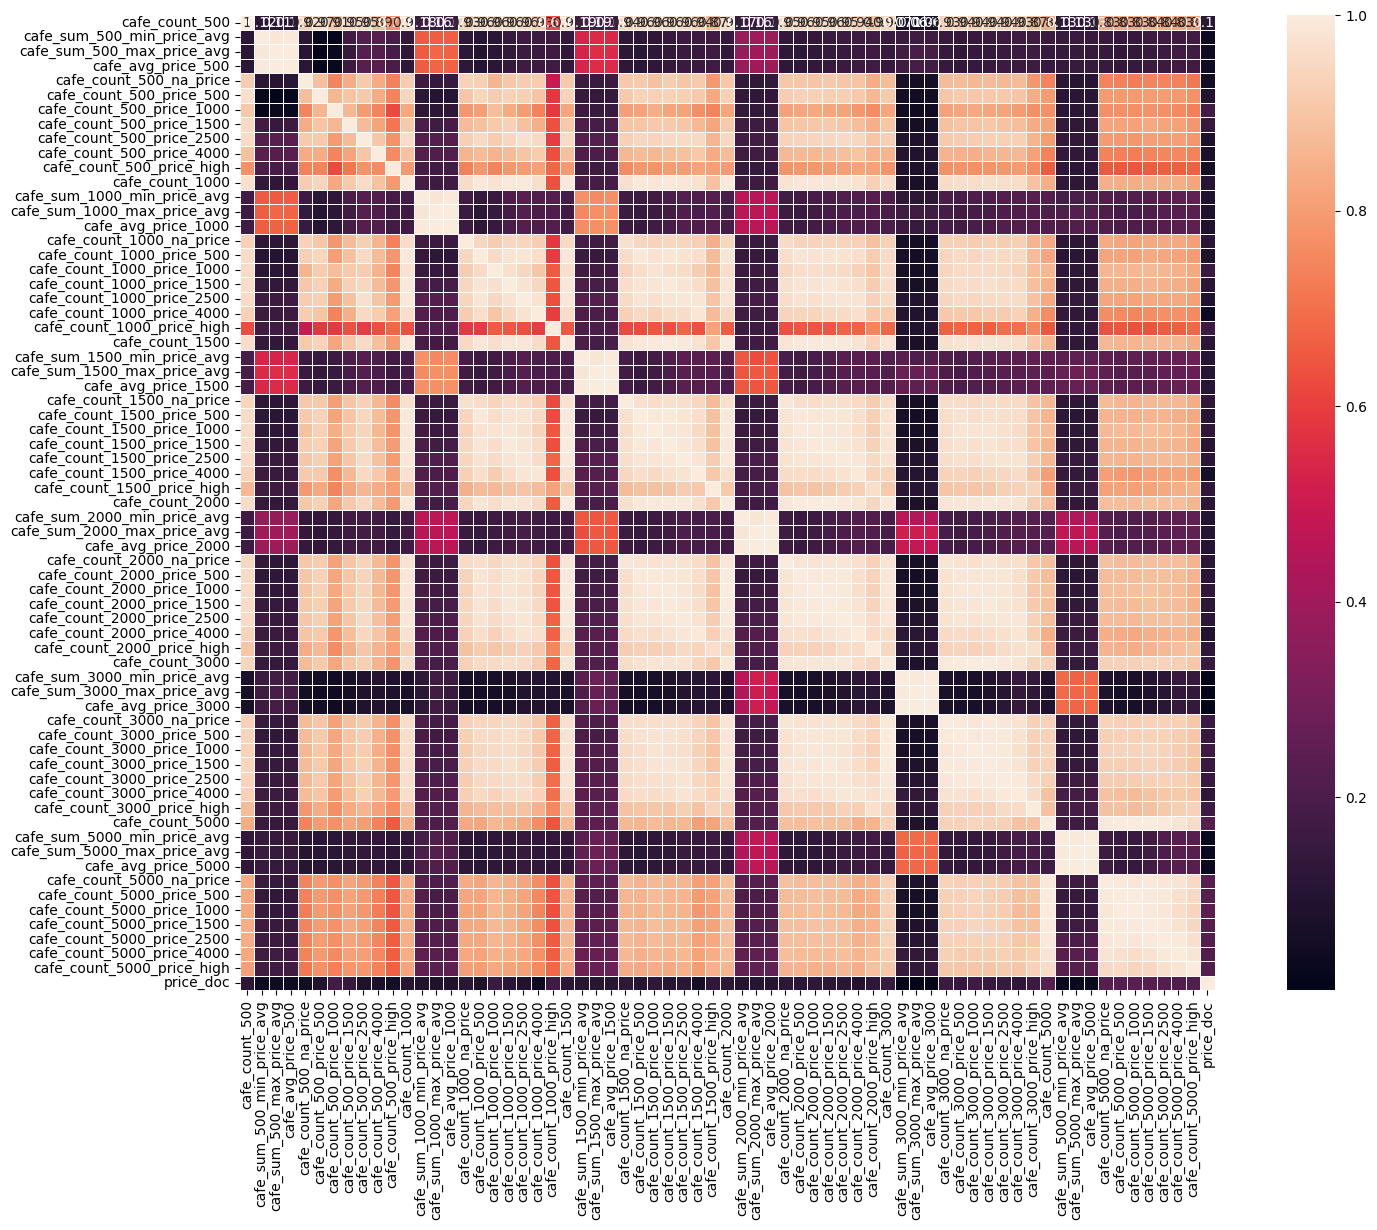

In [316]:
corrmat = df[cafe_list + ['price_doc']].corr()

plt.subplots(figsize=(18, 15))
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

In [317]:
# Break down of one-hot cols
for c in one_hot_cols:
    print(f"Number of unique values for {c}: {df[c].nunique()}")
    display(df[c].value_counts().head(20))

Number of unique values for product_type: 2


product_type
Investment       19448
OwnerOccupier    11023
Name: count, dtype: int64

Number of unique values for sub_area: 146


sub_area
Poselenie Sosenskoe         1776
Nekrasovka                  1611
Poselenie Vnukovskoe        1372
Poselenie Moskovskij         925
Poselenie Voskresenskoe      713
Mitino                       679
Tverskoe                     678
Krjukovo                     518
Mar'ino                      508
Poselenie Filimonkovskoe     496
Juzhnoe Butovo               451
Poselenie Shherbinka         443
Solncevo                     421
Zapadnoe Degunino            410
Poselenie Desjonovskoe       362
Otradnoe                     353
Nagatinskij Zaton            327
Bogorodskoe                  305
Nagornoe                     305
Strogino                     301
Name: count, dtype: int64

Number of unique values for ecology: 5


ecology
poor            8018
no data         7656
good            7174
excellent       3938
satisfactory    3685
Name: count, dtype: int64

## Pre-processing

In [318]:
# Replacing NAN with mean
df2 = df.copy()
# useless_cols += cafe_list
df2.drop(useless_cols, axis=1, inplace=True)


In [319]:
for c in cols_with_na:
    if c not in useless_cols and df2[c].dtype.name != 'category':
        df2[c] = df2[c].fillna((df2[c].mean()))

print("Columns with NAN after update: ")
df2.columns[df2.isna().any()].tolist()

Columns with NAN after update: 


['floor', 'max_floor', 'material', 'build_year', 'state']

### Label Encoding
For ordinal values

In [320]:
# Label encoding
le = LabelEncoder()
for c in le_cols:
    df2[c] = le.fit_transform(df2[c])

df2[le_cols].head()


,floor,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,month,year,material,max_floor,build_year,state
0,4,0,0,0,0,0,0,0,0,0,0,0,0,7,0,6,49,119,5
1,3,1,0,0,0,0,0,0,0,0,0,0,0,7,0,6,49,119,5
2,2,0,0,0,0,1,0,0,0,0,0,0,0,7,0,6,49,119,5
3,9,0,0,0,0,0,0,0,0,0,0,0,0,8,0,6,49,119,5
4,4,0,0,0,0,1,1,0,0,0,0,0,1,8,0,6,49,119,5


### Target Encoding for sub_area
Due to the many different values, target encoding is more approriate

In [321]:
X = df2.copy()
y = df2['price_doc']

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

In [322]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["sub_area"], m=10.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the sub_area column to create the final training data
X_train = encoder.transform(X_pretrain)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


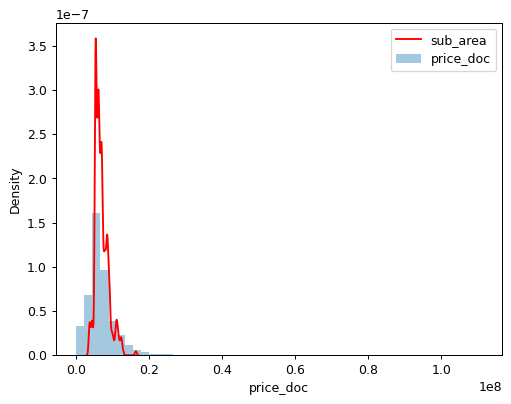

In [323]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train['sub_area'], color='r', ax=ax)
ax.set_xlabel("price_doc")
ax.legend(labels=['sub_area', 'price_doc'])

In [324]:
df2['sub_area_encoded'] = X_train['price_doc']

df2[['sub_area', 'sub_area_encoded']].head(10)

,sub_area,sub_area_encoded
0,Bibirevo,NaN
1,Nagatinskij Zaton,6000000.0
2,Tekstil'shhiki,5700000.0
3,Mitino,13100000.0
4,Basmannoe,16331452.0
5,Nizhegorodskoe,9100000.0
6,Sokol'niki,5500000.0
7,Bibirevo,2000000.0
8,Koptevo,5300000.0
9,Kuncevo,NaN


In [325]:
df2[df2['sub_area'] == 'Bibirevo'][['sub_area', 'sub_area_encoded']]

,sub_area,sub_area_encoded
0,Bibirevo,NaN
7,Bibirevo,2000000.0
32,Bibirevo,4900000.0
70,Bibirevo,5300000.0
102,Bibirevo,5950000.0
...,...,...
29558,Bibirevo,2000000.0
30008,Bibirevo,1000000.0
30060,Bibirevo,NaN
30214,Bibirevo,6350000.0


In [326]:
# # Drop NA columns
# df2 = df2[df2['sub_area_encoded'].notnull()]
df2.drop(['sub_area'], axis=1, inplace=True)

### One-hot Encoding

In [327]:
# One Hot Encoding
df2 = pd.get_dummies(df2, columns=['product_type', 'ecology'], dtype='int64')
df2.head()


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,year,month,sub_area_encoded,product_type_Investment,product_type_OwnerOccupier,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,43,27.0,4,49,6,119,1.909804,6.399301,5,6.407578e+06,...,0,7,NaN,1,0,0,1,0,0,0
1,34,19.0,3,49,6,119,1.909804,6.399301,5,9.589337e+06,...,0,7,6000000.0,1,0,1,0,0,0,0
2,43,29.0,2,49,6,119,1.909804,6.399301,5,4.808270e+06,...,0,7,5700000.0,1,0,0,0,0,1,0
3,89,50.0,9,49,6,119,1.909804,6.399301,5,1.258354e+07,...,0,8,13100000.0,1,0,0,1,0,0,0
4,77,77.0,4,49,6,119,1.909804,6.399301,5,8.398461e+06,...,0,8,16331452.0,1,0,1,0,0,0,0


In [328]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 290 entries, full_sq to ecology_satisfactory
dtypes: float64(114), int32(12), int64(164)
memory usage: 66.0 MB


No more cat data type!

## Split Dataset

In [329]:
y = df2['price_doc']
X = df2.drop(['price_doc'], axis=1)

display(y.head())
display(X.head())

0     5850000
1     6000000
2     5700000
3    13100000
4    16331452
Name: price_doc, dtype: int64

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,year,month,sub_area_encoded,product_type_Investment,product_type_OwnerOccupier,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,43,27.0,4,49,6,119,1.909804,6.399301,5,6.407578e+06,...,0,7,NaN,1,0,0,1,0,0,0
1,34,19.0,3,49,6,119,1.909804,6.399301,5,9.589337e+06,...,0,7,6000000.0,1,0,1,0,0,0,0
2,43,29.0,2,49,6,119,1.909804,6.399301,5,4.808270e+06,...,0,7,5700000.0,1,0,0,0,0,1,0
3,89,50.0,9,49,6,119,1.909804,6.399301,5,1.258354e+07,...,0,8,13100000.0,1,0,0,1,0,0,0
4,77,77.0,4,49,6,119,1.909804,6.399301,5,8.398461e+06,...,0,8,16331452.0,1,0,1,0,0,0,0


In [330]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
display(X_train.head())
display(y_train.head())

# # Convert to DMatrix
train_data = xgboost.DMatrix(X_train, label=y_train)
test_data = xgboost.DMatrix(X_test, label=y_test)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,year,month,sub_area_encoded,product_type_Investment,product_type_OwnerOccupier,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
15316,65,34.403271,4,10,3,112,2.0,10.0,0,2.149409e+07,...,3,1,NaN,0,1,0,0,1,0,0
14170,50,30.000000,17,17,0,92,2.0,8.0,1,2.615514e+07,...,3,0,7400000.0,1,0,0,1,0,0,0
12053,35,14.000000,7,11,1,119,1.0,10.0,5,5.234028e+06,...,2,10,5000000.0,1,0,0,0,0,1,0
26407,35,19.000000,9,12,4,65,1.0,9.0,1,3.879802e+06,...,3,11,6100000.0,1,0,0,1,0,0,0
19661,64,34.403271,19,24,0,119,2.0,1.0,5,2.553630e+07,...,3,5,7524720.0,0,1,0,0,1,0,0


15316    6561360
14170    7400000
12053    5000000
26407    6100000
19661    7524720
Name: price_doc, dtype: int64

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

In [331]:
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
}

In [332]:
n = 100
model = xgboost.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    )

[04:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [333]:
pred = model.predict(test_data)

[04:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [334]:
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


RMSE: 1567681.6328168842
R2: 0.895622516742022


- Weight. The number of times a feature is used to split the data across all trees.
- Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain. The average training loss reduction gained when using a feature for splitting.  [*MOST IMPORTANT*]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

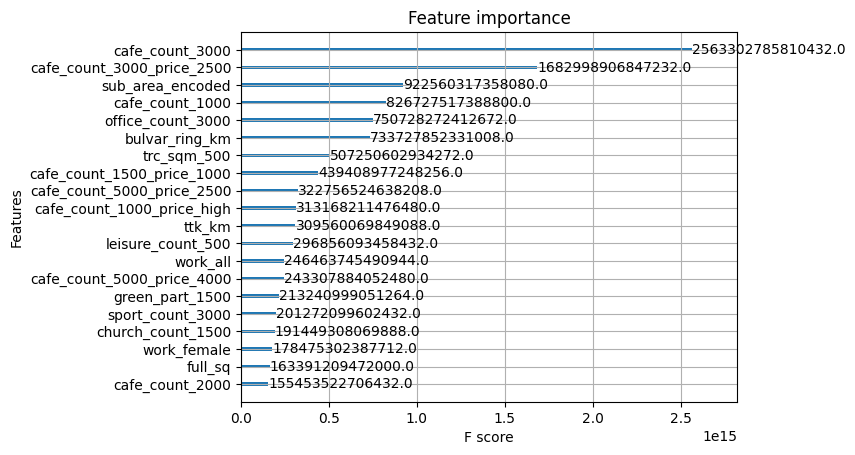

In [335]:
limit = 20
xgboost.plot_importance(model, importance_type='gain', max_num_features=limit)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

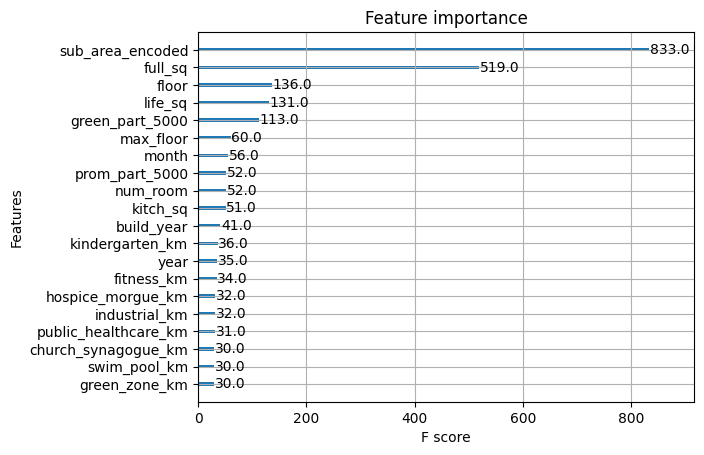

In [336]:
xgboost.plot_importance(model, importance_type='weight', max_num_features=limit)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

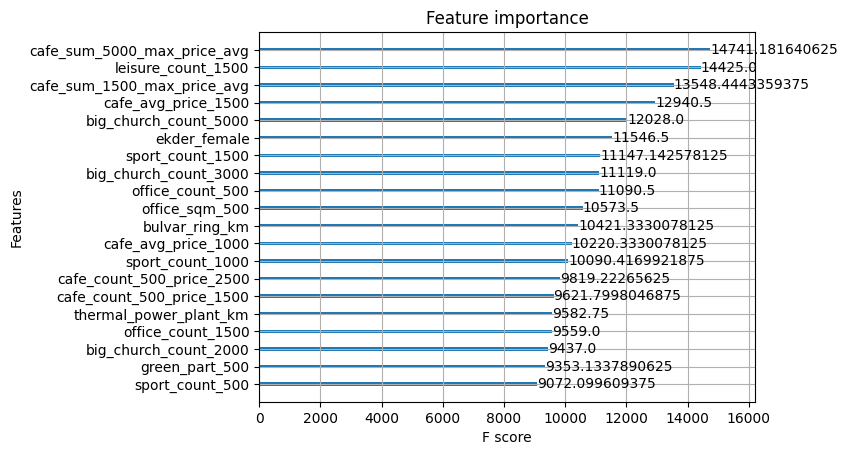

In [337]:
xgboost.plot_importance(model, importance_type='cover', max_num_features=limit)

In [338]:
params2 = {
    'n_estimators': 100,
    'device': 'cuda',
    # 'random_state': 24,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmsle',
    'enable_categorical': True,
    'eta': 0.1
}

In [339]:
model2 = XGBRegressor(n_estimaters=params2['n_estimators'],
                      device=params2['device'],
                    #   random_state=params2['random_state'],
                      objective=params2['objective'],
                      eval_metric=params2['eval_metric'],
                      enable_categorical=params2['enable_categorical'],
                      eta=params2['eta']
                      )

model2.fit(X_train, y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
[04:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimaters" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eta=0.1, eval_metric='rmsle',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimaters=100,
             n_estimators=None, n_jobs=None, ...)

In [340]:
pred = model2.predict(X_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [341]:
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


RMSE: 1525069.7845995314
R2: 0.9012196605671341


In [342]:
sorted_idx = model2.feature_importances_.argsort()[::-1]

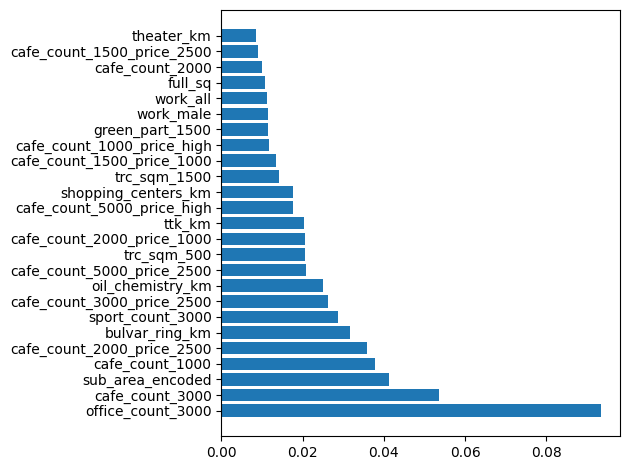

In [343]:
# limit = len(sorted_idx)
limit = 25
plt.barh(model2.feature_names_in_[sorted_idx[:limit]], model2.feature_importances_[sorted_idx[:limit]])
plt.tight_layout()

In [344]:
perm_importance = permutation_importance(model2, X_test, y_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated 

Text(0.5, 0, 'Permutation Importance')

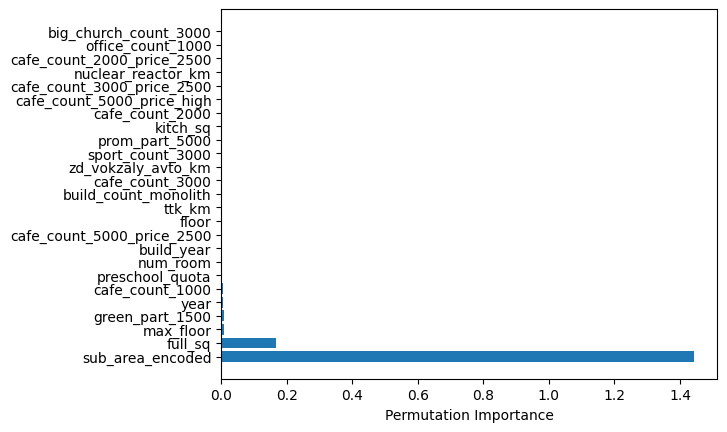

In [345]:
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.barh(model2.feature_names_in_[sorted_idx[:limit]], perm_importance.importances_mean[sorted_idx[:limit]])
plt.xlabel("Permutation Importance")

In [346]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test)

[04:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


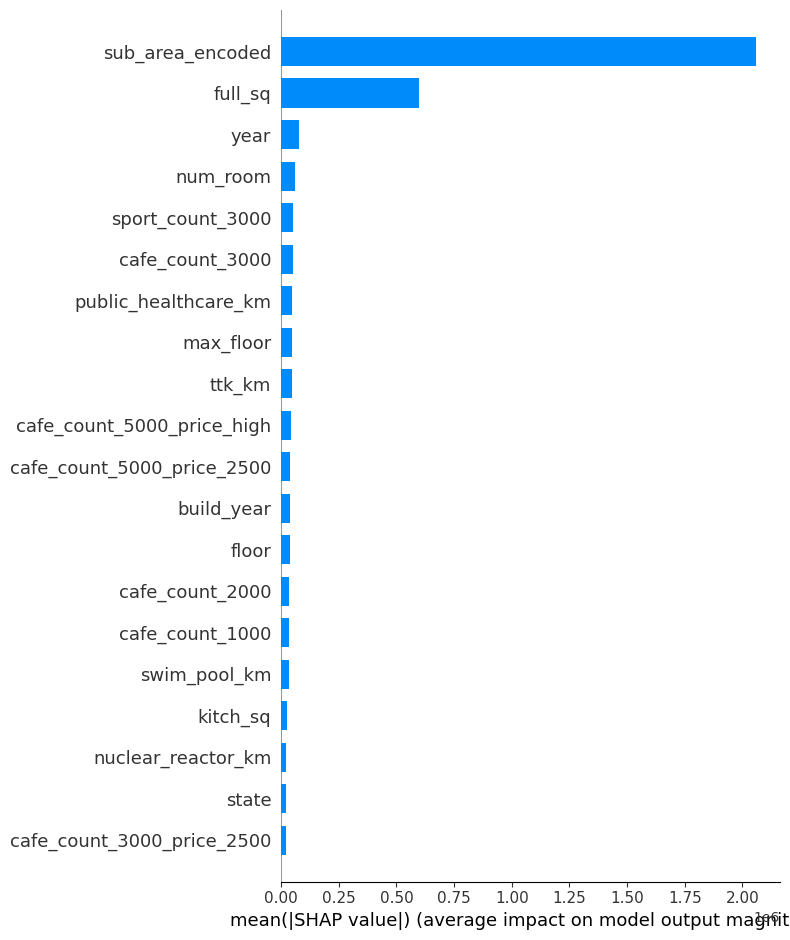

In [347]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Removing outliers

In [348]:
numeric_cols = set(df2.columns) - set(non_numeric_cols)
df3 = df2.copy()

for c in numeric_cols:
    try:
        df3 = df3[(np.abs(stats.zscore(df3[c])) < 3)]
    except:
        print("Error!", c)
        break

NameError: name 'non_numeric_cols' is not defined

In [ ]:
df3.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
